In [1]:
# pip install pyhealth

### STEP 1: load the chest Xray data

In [2]:
from pyhealth.datasets import COVID19CXRDataset

root = "/srv/local/data/COVID-19_Radiography_Dataset"
base_dataset = COVID19CXRDataset(root)

base_dataset.stat()

/home/chaoqiy2/miniconda3/envs/moltext/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Statistics of COVID19CXRDataset:
Number of samples: 21165
Number of classes: 4
Class distribution: Counter({'Normal': 10192, 'Lung Opacity': 6012, 'COVID': 3616, 'Viral Pneumonia': 1345})


### STEP 2: set task and processing the data

In [3]:
from torchvision import transforms

sample_dataset = base_dataset.set_task()

# the transformation automatically normalize the pixel intensity into [0, 1]
transform = transforms.Compose([
    transforms.Lambda(lambda x: x if x.shape[0] == 3 else x.repeat(3, 1, 1)), # only use the first channel
    transforms.Resize((128, 128)),
])

def encode(sample):
    sample["path"] = transform(sample["path"])
    return sample

sample_dataset.set_transform(encode)

Generating samples for COVID19CXRClassification: 100%|███████████████████████████████████████████| 21165/21165 [00:00<00:00, 1922022.30it/s]


In [4]:
from pyhealth.datasets import split_by_visit, get_dataloader

# split dataset
train_dataset, val_dataset, test_dataset = split_by_visit(
    sample_dataset, [0.8, 0.1, 0.1]
)
train_dataloader = get_dataloader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = get_dataloader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = get_dataloader(test_dataset, batch_size=256, shuffle=False)

In [5]:
data = next(iter(train_dataloader))
print (data["path"][0].shape)

print(
    "loader size: train/val/test",
    len(train_dataset),
    len(val_dataset),
    len(test_dataset),
)

torch.Size([3, 128, 128])
loader size: train/val/test 16932 2116 2117


### STEP 3: initialize the VAE model

In [6]:
from pyhealth.models import VAE

model = VAE(
    dataset=sample_dataset,
    input_channel=3,
    input_size=128,
    feature_keys=["path"],
    label_key="path",
    mode="regression",
    hidden_dim = 256,
)

### STEP 4: define trainer

In [7]:
from pyhealth.trainer import Trainer

trainer = Trainer(model=model, device="cuda:4", metrics=["kl_divergence", "mse", "mae"])
trainer.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=20,
    monitor = "kl_divergence",
    monitor_criterion = 'min',
    optimizer_params={"lr": 1e-3},
)

VAE(
  (encoder1): Sequential(
    (0): ResBlock2D(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ELU(alpha=1.0)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (downsample): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): ResBlock2D(
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ELU(alp

Epoch 0 / 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]

--- Train epoch-0, step-67 ---
loss: 7853681.3489



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.10it/s]


--- Eval epoch-0, step-67 ---
kl_divergence: 0.1531
mse: 0.0000
mae: 0.0000
loss: 6813482.7778
New best kl_divergence score (0.1531) at epoch-0, step-67



Epoch 1 / 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:01<00:00,  1.09it/s]

--- Train epoch-1, step-134 ---
loss: 7269614.4039



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s]


--- Eval epoch-1, step-134 ---
kl_divergence: 0.1448
mse: 0.0000
mae: 0.0000
loss: 6721105.7222
New best kl_divergence score (0.1448) at epoch-1, step-134



Epoch 2 / 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]

--- Train epoch-2, step-201 ---
loss: 7193637.5196



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08it/s]


--- Eval epoch-2, step-201 ---
kl_divergence: 0.0814
mse: 0.0000
mae: 0.0000
loss: 6604489.8750
New best kl_divergence score (0.0814) at epoch-2, step-201



Epoch 3 / 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:01<00:00,  1.09it/s]

--- Train epoch-3, step-268 ---
loss: 7142792.3386



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.12it/s]


--- Eval epoch-3, step-268 ---
kl_divergence: 0.0750
mse: 0.0000
mae: 0.0000
loss: 6609193.9722
New best kl_divergence score (0.0750) at epoch-3, step-268



Epoch 4 / 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.17it/s]

--- Train epoch-4, step-335 ---
loss: 7118568.2015



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.48it/s]


--- Eval epoch-4, step-335 ---
kl_divergence: 0.0546
mse: 0.0000
mae: 0.0000
loss: 6568004.0833
New best kl_divergence score (0.0546) at epoch-4, step-335



Epoch 5 / 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:45<00:00,  1.46it/s]

--- Train epoch-5, step-402 ---
loss: 7100631.7071



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.45it/s]


--- Eval epoch-5, step-402 ---
kl_divergence: 0.0584
mse: 0.0000
mae: 0.0000
loss: 6594770.8333



Epoch 6 / 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:45<00:00,  1.49it/s]

--- Train epoch-6, step-469 ---
loss: 7079662.5933



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.59it/s]


--- Eval epoch-6, step-469 ---
kl_divergence: 0.0465
mse: 0.0000
mae: 0.0000
loss: 6533144.2361
New best kl_divergence score (0.0465) at epoch-6, step-469



Epoch 7 / 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:44<00:00,  1.50it/s]

--- Train epoch-7, step-536 ---
loss: 7060642.8265



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.56it/s]


--- Eval epoch-7, step-536 ---
kl_divergence: 0.0542
mse: 0.0000
mae: 0.0000
loss: 6531832.1250



Epoch 8 / 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:45<00:00,  1.48it/s]

--- Train epoch-8, step-603 ---
loss: 7057253.8116



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.61it/s]


--- Eval epoch-8, step-603 ---
kl_divergence: 0.0484
mse: 0.0000
mae: 0.0000
loss: 6521821.5972



Epoch 9 / 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:44<00:00,  1.51it/s]

--- Train epoch-9, step-670 ---
loss: 7040469.0168



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.65it/s]


--- Eval epoch-9, step-670 ---
kl_divergence: 0.0419
mse: 0.0000
mae: 0.0000
loss: 6500187.3194
New best kl_divergence score (0.0419) at epoch-9, step-670



Epoch 10 / 20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:44<00:00,  1.52it/s]

--- Train epoch-10, step-737 ---
loss: 7034561.5196



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.68it/s]


--- Eval epoch-10, step-737 ---
kl_divergence: 0.0423
mse: 0.0000
mae: 0.0000
loss: 6508993.3333



Epoch 11 / 20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:43<00:00,  1.53it/s]

--- Train epoch-11, step-804 ---
loss: 7028912.4543



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.65it/s]


--- Eval epoch-11, step-804 ---
kl_divergence: 0.0338
mse: 0.0000
mae: 0.0000
loss: 6510866.0417
New best kl_divergence score (0.0338) at epoch-11, step-804



Epoch 12 / 20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:43<00:00,  1.56it/s]

--- Train epoch-12, step-871 ---
loss: 7027013.5933



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.63it/s]


--- Eval epoch-12, step-871 ---
kl_divergence: 0.0437
mse: 0.0000
mae: 0.0000
loss: 6491712.3194



Epoch 13 / 20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:44<00:00,  1.52it/s]

--- Train epoch-13, step-938 ---
loss: 7018141.4291



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.60it/s]


--- Eval epoch-13, step-938 ---
kl_divergence: 0.0470
mse: 0.0000
mae: 0.0000
loss: 6505837.5139



Epoch 14 / 20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:44<00:00,  1.50it/s]

--- Train epoch-14, step-1005 ---
loss: 7018323.3498



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.61it/s]


--- Eval epoch-14, step-1005 ---
kl_divergence: 0.0527
mse: 0.0000
mae: 0.0000
loss: 6499927.8889



Epoch 15 / 20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:43<00:00,  1.53it/s]

--- Train epoch-15, step-1072 ---
loss: 7012684.5364



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.66it/s]


--- Eval epoch-15, step-1072 ---
kl_divergence: 0.0354
mse: 0.0000
mae: 0.0000
loss: 6472468.5972



Epoch 16 / 20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:43<00:00,  1.55it/s]

--- Train epoch-16, step-1139 ---
loss: 7009036.7724



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.53it/s]


--- Eval epoch-16, step-1139 ---
kl_divergence: 0.0327
mse: 0.0000
mae: 0.0000
loss: 6488543.6111
New best kl_divergence score (0.0327) at epoch-16, step-1139



Epoch 17 / 20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:46<00:00,  1.44it/s]

--- Train epoch-17, step-1206 ---
loss: 7007894.7985



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.57it/s]


--- Eval epoch-17, step-1206 ---
kl_divergence: 0.0428
mse: 0.0000
mae: 0.0000
loss: 6477742.8194



Epoch 18 / 20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:45<00:00,  1.49it/s]

--- Train epoch-18, step-1273 ---
loss: 6998958.7080



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.59it/s]


--- Eval epoch-18, step-1273 ---
kl_divergence: 0.0374
mse: 0.0000
mae: 0.0000
loss: 6475522.2083



Epoch 19 / 20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:44<00:00,  1.49it/s]

--- Train epoch-19, step-1340 ---
loss: 6998535.8526



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.59it/s]


--- Eval epoch-19, step-1340 ---
kl_divergence: 0.0323
mse: 0.0000
mae: 0.0000
loss: 6478588.5000
New best kl_divergence score (0.0323) at epoch-19, step-1340
Loaded best model


### STEP 5: evaluate

In [8]:
# evaluate on the test data
print(trainer.evaluate(test_dataloader))

Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.60it/s]


{'kl_divergence': 0.03204501, 'mse': 1.7194245e-18, 'mae': 8.95354e-10, 'loss': 6494522.055555556}


### EXP 1: we check the original chest Xray image and the reconstructed ones

In [9]:
X, X_rec, _ = trainer.inference(test_dataloader)

Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.59it/s]


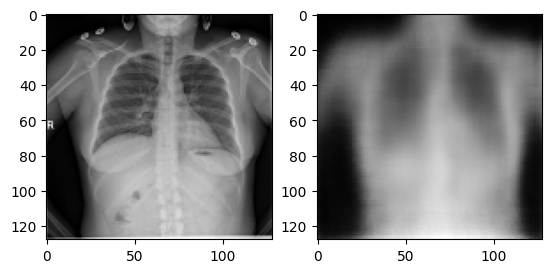

In [13]:
import matplotlib.pyplot as plt

idx = 10
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(X[idx].reshape(3, 128, 128)[0], cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(X_rec[idx].reshape(3, 128, 128)[0], cmap="gray")
plt.show()

### EXP 2: synthesize random images

torch.Size([1, 256, 1, 1])


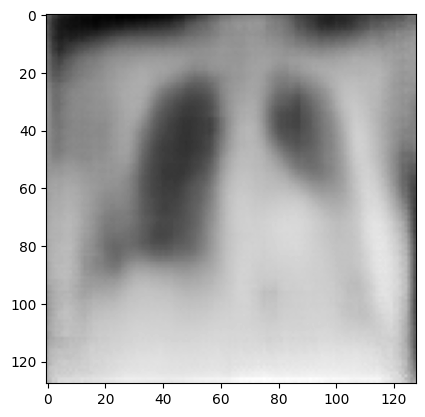

In [23]:
import torch
import numpy as np

model = trainer.model
  
model.eval()
with torch.no_grad():
    # we generate a random 64-dimensional multi-gaussian vector
    x = np.random.normal(0, 1, 256)
    
    x = x.astype(np.float32)
    x = torch.from_numpy(x).to(trainer.device).unsqueeze(0).unsqueeze(2).unsqueeze(3)
    print (x.shape)
    rec = model.decoder(x).detach().cpu().numpy()
    rec = rec.reshape((3, 128, 128))[0]
    plt.imshow(rec, cmap="gray")
    plt.show()